In [4]:
using Pkg
Pkg.activate("Dev")
using Revise
using Skylight
using CairoMakie

  Activating project at `~/repos/Skylight.jl/run/Dev`


In [35]:
distance = 500
N = 25
spacetime = KerrSpacetimeBoyerLindquistCoordinates(M=1.0,a=0.5)
camera = PinholeCamera(position = [0.0, distance, π/2-π/20, 0.0],
                        horizontal_aperture_in_degrees = rad2deg(315/distance),
                        vertical_aperture_in_degrees = rad2deg(315/distance),
                        horizontal_number_of_pixels = N,
                        vertical_number_of_pixels = N)
model = IonTorus(spacetime)
configurations = NonVacuumOTEConfigurations(spacetime=spacetime,
                                   camera = camera,
                                   radiative_model = model,
                                   unit_mass_in_solar_masses=1.0,
                                   observation_energies = [1e-9])
initial_data = initialize(configurations)
cb, cbp = callback_setup(configurations; rhorizon_bound=2e-3) #... or, define your own cb and cbp
run = integrate(initial_data, configurations, cb, cbp; method=VCABM(), reltol=1e-5, abstol=1e-5)
output_data = run.output_data

CompositeException: TaskFailedException

    nested task error: DomainError with -7.647471565981049:
    log will only return a complex result if called with a complex argument. Try log(Complex(x)).
    DomainError detected in the user `f` function. This occurs when the domain of a function is violated.
    For example, `log(-1.0)` is undefined because `log` of a real number is defined to only output real
    numbers, but `log` of a negative number is complex valued and therefore Julia throws a DomainError
    by default. Cases to be aware of include:
    
    * `log(x)`, `sqrt(x)`, `cbrt(x)`, etc. where `x<0`
    * `x^y` for `x<0` floating point `y` (example: `(-1.0)^(1/2) == im`)
    
    Within the context of SciML, this error can occur within the solver process even if the domain constraint
    would not be violated in the solution due to adaptivity. For example, an ODE solver or optimization
    routine may check a step at `new_u` which violates the domain constraint, and if violated reject the
    step and use a smaller `dt`. However, the throwing of this error will have halted the solving process.
    
    Thus the recommended fix is to replace this function with the equivalent ones from NaNMath.jl
    (https://github.com/JuliaMath/NaNMath.jl) which returns a NaN instead of an error. The solver will then
    effectively use the NaN within the error control routines to reject the out of bounds step. Additionally,
    one could perform a domain transformation on the variables so that such an issue does not occur in the
    definition of `f`.
    
    For more information, check out the following FAQ page:
    https://docs.sciml.ai/Optimization/stable/API/FAQ/#The-Solver-Seems-to-Violate-Constraints-During-the-Optimization,-Causing-DomainErrors,-What-Can-I-Do-About-That?
    
    Stacktrace:
      [1] throw_complex_domainerror(f::Symbol, x::Float64)
        @ Base.Math ./math.jl:33
      [2] _log(x::Float64, base::Val{:ℯ}, func::Symbol)
        @ Base.Math ./special/log.jl:301
      [3] log
        @ ./special/log.jl:267 [inlined]
      [4] torus_potential(g::Matrix{Float64}, model::IonTorus{ProgradeRotation, Bremsstrahlung})
        @ Skylight ~/repos/Skylight.jl/src/radiativemodels/iontorus.jl:81
      [5] torus_normalized_potential
        @ ~/repos/Skylight.jl/src/radiativemodels/iontorus.jl:95 [inlined]
      [6] rest_frame_four_velocity!(vector::Vector{Float64}, position::SubArray{Float64, 1, StaticArraysCore.SVector{10, Float64}, Tuple{UnitRange{Int64}}, true}, metric::Matrix{Float64}, spacetime::KerrSpacetimeBoyerLindquistCoordinates, model::IonTorus{ProgradeRotation, Bremsstrahlung}, coords_top::SphericalTopology)
        @ Skylight ~/repos/Skylight.jl/src/radiativemodels/iontorus.jl:230
      [7] transfer_equations(u::StaticArraysCore.SVector{10, Float64}, p::Skylight.NonVacuumCache{KerrSpacetimeBoyerLindquistCoordinates, IonTorus{ProgradeRotation, Bremsstrahlung}, Skylight.IonTorusCallbackParameters, Nothing, Skylight.AutoDiffChristoffelCache{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Nothing, ForwardDiff.JacobianConfig{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4, Tuple{Matrix{ForwardDiff.Dual{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4}}}}}, SphericalTopology}, t::Float64)
        @ Skylight ~/repos/Skylight.jl/src/transfer/equations.jl:73
      [8] non_vacuum_equations(u::StaticArraysCore.SVector{10, Float64}, p::Skylight.NonVacuumCache{KerrSpacetimeBoyerLindquistCoordinates, IonTorus{ProgradeRotation, Bremsstrahlung}, Skylight.IonTorusCallbackParameters, Nothing, Skylight.AutoDiffChristoffelCache{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Nothing, ForwardDiff.JacobianConfig{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4, Tuple{Matrix{ForwardDiff.Dual{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4}}}}}, SphericalTopology}, t::Float64)
        @ Skylight ~/repos/Skylight.jl/src/transfer/equations.jl:7
      [9] ODEFunction
        @ ~/.julia/packages/SciMLBase/qp2gL/src/scimlfunctions.jl:2126 [inlined]
     [10] perform_step!(integrator::OrdinaryDiffEq.ODEIntegrator{VCABM, false, StaticArraysCore.SVector{10, Float64}, Nothing, Float64, Skylight.NonVacuumCache{KerrSpacetimeBoyerLindquistCoordinates, IonTorus{ProgradeRotation, Bremsstrahlung}, Skylight.IonTorusCallbackParameters, Nothing, Skylight.AutoDiffChristoffelCache{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Nothing, ForwardDiff.JacobianConfig{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4, Tuple{Matrix{ForwardDiff.Dual{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4}}}}}, SphericalTopology}, Float64, Float64, Float64, Float64, Vector{StaticArraysCore.SVector{10, Float64}}, ODESolution{Float64, 2, Vector{StaticArraysCore.SVector{10, Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{StaticArraysCore.SVector{10, Float64}}}, ODEProblem{StaticArraysCore.SVector{10, Float64}, Tuple{Float64, Float64}, false, Skylight.NonVacuumCache{KerrSpacetimeBoyerLindquistCoordinates, IonTorus{ProgradeRotation, Bremsstrahlung}, Skylight.IonTorusCallbackParameters, Nothing, Skylight.AutoDiffChristoffelCache{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Nothing, ForwardDiff.JacobianConfig{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4, Tuple{Matrix{ForwardDiff.Dual{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4}}}}}, SphericalTopology}, ODEFunction{false, SciMLBase.AutoSpecialize, typeof(Skylight.non_vacuum_equations), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, VCABM, OrdinaryDiffEq.InterpolationData{ODEFunction{false, SciMLBase.AutoSpecialize, typeof(Skylight.non_vacuum_equations), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Vector{StaticArraysCore.SVector{10, Float64}}, Vector{Float64}, Vector{Vector{StaticArraysCore.SVector{10, Float64}}}, OrdinaryDiffEq.VCABMConstantCache{Vector{Float64}, Vector{StaticArraysCore.SVector{10, Float64}}, Matrix{Float64}, Float64, Vector{Float64}}}, DiffEqBase.Stats, Nothing}, ODEFunction{false, SciMLBase.AutoSpecialize, typeof(Skylight.non_vacuum_equations), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, OrdinaryDiffEq.VCABMConstantCache{Vector{Float64}, Vector{StaticArraysCore.SVector{10, Float64}}, Matrix{Float64}, Float64, Vector{Float64}}, OrdinaryDiffEq.DEOptions{Float64, Float64, Float64, Float64, IController, typeof(DiffEqBase.ODE_DEFAULT_NORM), typeof(LinearAlgebra.opnorm), Nothing, CallbackSet{Tuple{ContinuousCallback{typeof(Skylight.iontorus_condition), typeof(Skylight.iontorus_affect!), typeof(Skylight.iontorus_affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Int64}}, Tuple{DiscreteCallback{typeof(Skylight.opacities_condition), typeof(terminate!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}}}, typeof(DiffEqBase.ODE_DEFAULT_ISOUTOFDOMAIN), typeof(DiffEqBase.ODE_DEFAULT_PROG_MESSAGE), typeof(DiffEqBase.ODE_DEFAULT_UNSTABLE_CHECK), DataStructures.BinaryHeap{Float64, DataStructures.FasterForward}, DataStructures.BinaryHeap{Float64, DataStructures.FasterForward}, Nothing, Nothing, Int64, Tuple{}, Tuple{}, Tuple{}}, StaticArraysCore.SVector{10, Float64}, Float64, Nothing, OrdinaryDiffEq.DefaultInit}, cache::OrdinaryDiffEq.VCABMConstantCache{Vector{Float64}, Vector{StaticArraysCore.SVector{10, Float64}}, Matrix{Float64}, Float64, Vector{Float64}}, repeat_step::Bool)
        @ OrdinaryDiffEq ~/.julia/packages/OrdinaryDiffEq/EQy59/src/perform_step/adams_bashforth_moulton_perform_step.jl:1403
     [11] perform_step!
        @ ~/.julia/packages/OrdinaryDiffEq/EQy59/src/perform_step/adams_bashforth_moulton_perform_step.jl:1386 [inlined]
     [12] solve!(integrator::OrdinaryDiffEq.ODEIntegrator{VCABM, false, StaticArraysCore.SVector{10, Float64}, Nothing, Float64, Skylight.NonVacuumCache{KerrSpacetimeBoyerLindquistCoordinates, IonTorus{ProgradeRotation, Bremsstrahlung}, Skylight.IonTorusCallbackParameters, Nothing, Skylight.AutoDiffChristoffelCache{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Nothing, ForwardDiff.JacobianConfig{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4, Tuple{Matrix{ForwardDiff.Dual{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4}}}}}, SphericalTopology}, Float64, Float64, Float64, Float64, Vector{StaticArraysCore.SVector{10, Float64}}, ODESolution{Float64, 2, Vector{StaticArraysCore.SVector{10, Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{StaticArraysCore.SVector{10, Float64}}}, ODEProblem{StaticArraysCore.SVector{10, Float64}, Tuple{Float64, Float64}, false, Skylight.NonVacuumCache{KerrSpacetimeBoyerLindquistCoordinates, IonTorus{ProgradeRotation, Bremsstrahlung}, Skylight.IonTorusCallbackParameters, Nothing, Skylight.AutoDiffChristoffelCache{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Nothing, ForwardDiff.JacobianConfig{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4, Tuple{Matrix{ForwardDiff.Dual{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4}}}}}, SphericalTopology}, ODEFunction{false, SciMLBase.AutoSpecialize, typeof(Skylight.non_vacuum_equations), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, VCABM, OrdinaryDiffEq.InterpolationData{ODEFunction{false, SciMLBase.AutoSpecialize, typeof(Skylight.non_vacuum_equations), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Vector{StaticArraysCore.SVector{10, Float64}}, Vector{Float64}, Vector{Vector{StaticArraysCore.SVector{10, Float64}}}, OrdinaryDiffEq.VCABMConstantCache{Vector{Float64}, Vector{StaticArraysCore.SVector{10, Float64}}, Matrix{Float64}, Float64, Vector{Float64}}}, DiffEqBase.Stats, Nothing}, ODEFunction{false, SciMLBase.AutoSpecialize, typeof(Skylight.non_vacuum_equations), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, OrdinaryDiffEq.VCABMConstantCache{Vector{Float64}, Vector{StaticArraysCore.SVector{10, Float64}}, Matrix{Float64}, Float64, Vector{Float64}}, OrdinaryDiffEq.DEOptions{Float64, Float64, Float64, Float64, IController, typeof(DiffEqBase.ODE_DEFAULT_NORM), typeof(LinearAlgebra.opnorm), Nothing, CallbackSet{Tuple{ContinuousCallback{typeof(Skylight.iontorus_condition), typeof(Skylight.iontorus_affect!), typeof(Skylight.iontorus_affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Int64}}, Tuple{DiscreteCallback{typeof(Skylight.opacities_condition), typeof(terminate!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}}}, typeof(DiffEqBase.ODE_DEFAULT_ISOUTOFDOMAIN), typeof(DiffEqBase.ODE_DEFAULT_PROG_MESSAGE), typeof(DiffEqBase.ODE_DEFAULT_UNSTABLE_CHECK), DataStructures.BinaryHeap{Float64, DataStructures.FasterForward}, DataStructures.BinaryHeap{Float64, DataStructures.FasterForward}, Nothing, Nothing, Int64, Tuple{}, Tuple{}, Tuple{}}, StaticArraysCore.SVector{10, Float64}, Float64, Nothing, OrdinaryDiffEq.DefaultInit})
        @ OrdinaryDiffEq ~/.julia/packages/OrdinaryDiffEq/EQy59/src/solve.jl:520
     [13] #__solve#640
        @ ~/.julia/packages/OrdinaryDiffEq/EQy59/src/solve.jl:6 [inlined]
     [14] __solve
        @ ~/.julia/packages/OrdinaryDiffEq/EQy59/src/solve.jl:1 [inlined]
     [15] #solve_call#22
        @ ~/.julia/packages/DiffEqBase/HoOGI/src/solve.jl:511 [inlined]
     [16] solve_up(prob::ODEProblem{StaticArraysCore.SVector{10, Float64}, Tuple{Float64, Float64}, false, Skylight.NonVacuumCache{KerrSpacetimeBoyerLindquistCoordinates, IonTorus{ProgradeRotation, Bremsstrahlung}, Skylight.IonTorusCallbackParameters, Nothing, Skylight.AutoDiffChristoffelCache{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Nothing, ForwardDiff.JacobianConfig{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4, Tuple{Matrix{ForwardDiff.Dual{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4}}}}}, SphericalTopology}, ODEFunction{false, SciMLBase.AutoSpecialize, typeof(Skylight.non_vacuum_equations), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, sensealg::Nothing, u0::StaticArraysCore.SVector{10, Float64}, p::Skylight.NonVacuumCache{KerrSpacetimeBoyerLindquistCoordinates, IonTorus{ProgradeRotation, Bremsstrahlung}, Skylight.IonTorusCallbackParameters, Nothing, Skylight.AutoDiffChristoffelCache{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Nothing, ForwardDiff.JacobianConfig{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4, Tuple{Matrix{ForwardDiff.Dual{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4}}}}}, SphericalTopology}, args::VCABM; kwargs::Base.Pairs{Symbol, Any, Tuple{Symbol, Symbol, Symbol}, NamedTuple{(:callback, :reltol, :abstol), Tuple{CallbackSet{Tuple{ContinuousCallback{typeof(Skylight.iontorus_condition), typeof(Skylight.iontorus_affect!), typeof(Skylight.iontorus_affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Int64}}, Tuple{DiscreteCallback{typeof(Skylight.opacities_condition), typeof(terminate!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}}}, Float64, Float64}}})
        @ DiffEqBase ~/.julia/packages/DiffEqBase/HoOGI/src/solve.jl:972
     [17] solve_up
        @ ~/.julia/packages/DiffEqBase/HoOGI/src/solve.jl:945 [inlined]
     [18] solve(prob::ODEProblem{StaticArraysCore.SVector{10, Float64}, Tuple{Float64, Float64}, false, Skylight.NonVacuumCache{KerrSpacetimeBoyerLindquistCoordinates, IonTorus{ProgradeRotation, Bremsstrahlung}, Skylight.IonTorusCallbackParameters, Nothing, Skylight.AutoDiffChristoffelCache{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Nothing, ForwardDiff.JacobianConfig{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4, Tuple{Matrix{ForwardDiff.Dual{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4}}}}}, SphericalTopology}, ODEFunction{false, SciMLBase.AutoSpecialize, typeof(Skylight.non_vacuum_equations), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, args::VCABM; sensealg::Nothing, u0::Nothing, p::Nothing, wrap::Val{true}, kwargs::Base.Pairs{Symbol, Any, Tuple{Symbol, Symbol, Symbol}, NamedTuple{(:callback, :reltol, :abstol), Tuple{CallbackSet{Tuple{ContinuousCallback{typeof(Skylight.iontorus_condition), typeof(Skylight.iontorus_affect!), typeof(Skylight.iontorus_affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Int64}}, Tuple{DiscreteCallback{typeof(Skylight.opacities_condition), typeof(terminate!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}}}, Float64, Float64}}})
        @ DiffEqBase ~/.julia/packages/DiffEqBase/HoOGI/src/solve.jl:882
     [19] batch_func(i::Int64, prob::EnsembleProblem{ODEProblem{StaticArraysCore.SVector{10, Float64}, Tuple{Float64, Float64}, false, Skylight.NonVacuumCache{KerrSpacetimeBoyerLindquistCoordinates, IonTorus{ProgradeRotation, Bremsstrahlung}, Skylight.IonTorusCallbackParameters, Nothing, Skylight.AutoDiffChristoffelCache{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Nothing, ForwardDiff.JacobianConfig{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4, Tuple{Matrix{ForwardDiff.Dual{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4}}}}}, SphericalTopology}, ODEFunction{false, SciMLBase.AutoSpecialize, typeof(Skylight.non_vacuum_equations), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Skylight.var"#prob_func#266"{Matrix{Float64}, Int64}, Skylight.var"#output_func#265", typeof(SciMLBase.DEFAULT_REDUCTION), Nothing}, alg::VCABM; kwargs::Base.Pairs{Symbol, Any, Tuple{Symbol, Symbol, Symbol}, NamedTuple{(:callback, :reltol, :abstol), Tuple{CallbackSet{Tuple{ContinuousCallback{typeof(Skylight.iontorus_condition), typeof(Skylight.iontorus_affect!), typeof(Skylight.iontorus_affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Int64}}, Tuple{DiscreteCallback{typeof(Skylight.opacities_condition), typeof(terminate!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}}}, Float64, Float64}}})
        @ SciMLBase ~/.julia/packages/SciMLBase/qp2gL/src/ensemble/basic_ensemble_solve.jl:92
     [20] batch_func
        @ ~/.julia/packages/SciMLBase/qp2gL/src/ensemble/basic_ensemble_solve.jl:87 [inlined]
     [21] #544
        @ ~/.julia/packages/SciMLBase/qp2gL/src/ensemble/basic_ensemble_solve.jl:165 [inlined]
     [22] macro expansion
        @ ~/.julia/packages/SciMLBase/qp2gL/src/ensemble/basic_ensemble_solve.jl:174 [inlined]
     [23] (::SciMLBase.var"#932#threadsfor_fun#548"{SciMLBase.var"#932#threadsfor_fun#547#549"{SciMLBase.var"#544#546"{Base.Pairs{Symbol, Any, Tuple{Symbol, Symbol, Symbol}, NamedTuple{(:callback, :reltol, :abstol), Tuple{CallbackSet{Tuple{ContinuousCallback{typeof(Skylight.iontorus_condition), typeof(Skylight.iontorus_affect!), typeof(Skylight.iontorus_affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Int64}}, Tuple{DiscreteCallback{typeof(Skylight.opacities_condition), typeof(terminate!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}}}, Float64, Float64}}}, EnsembleProblem{ODEProblem{StaticArraysCore.SVector{10, Float64}, Tuple{Float64, Float64}, false, Skylight.NonVacuumCache{KerrSpacetimeBoyerLindquistCoordinates, IonTorus{ProgradeRotation, Bremsstrahlung}, Skylight.IonTorusCallbackParameters, Nothing, Skylight.AutoDiffChristoffelCache{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Nothing, ForwardDiff.JacobianConfig{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4, Tuple{Matrix{ForwardDiff.Dual{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4}}}}}, SphericalTopology}, ODEFunction{false, SciMLBase.AutoSpecialize, typeof(Skylight.non_vacuum_equations), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Skylight.var"#prob_func#266"{Matrix{Float64}, Int64}, Skylight.var"#output_func#265", typeof(SciMLBase.DEFAULT_REDUCTION), Nothing}, VCABM}, Tuple{UnitRange{Int64}}, Vector{Any}, UnitRange{Int64}}})(tid::Int64; onethread::Bool)
        @ SciMLBase ./threadingconstructs.jl:163
     [24] #932#threadsfor_fun
        @ ./threadingconstructs.jl:130 [inlined]
     [25] (::Base.Threads.var"#1#2"{SciMLBase.var"#932#threadsfor_fun#548"{SciMLBase.var"#932#threadsfor_fun#547#549"{SciMLBase.var"#544#546"{Base.Pairs{Symbol, Any, Tuple{Symbol, Symbol, Symbol}, NamedTuple{(:callback, :reltol, :abstol), Tuple{CallbackSet{Tuple{ContinuousCallback{typeof(Skylight.iontorus_condition), typeof(Skylight.iontorus_affect!), typeof(Skylight.iontorus_affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Int64}}, Tuple{DiscreteCallback{typeof(Skylight.opacities_condition), typeof(terminate!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}}}, Float64, Float64}}}, EnsembleProblem{ODEProblem{StaticArraysCore.SVector{10, Float64}, Tuple{Float64, Float64}, false, Skylight.NonVacuumCache{KerrSpacetimeBoyerLindquistCoordinates, IonTorus{ProgradeRotation, Bremsstrahlung}, Skylight.IonTorusCallbackParameters, Nothing, Skylight.AutoDiffChristoffelCache{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Nothing, ForwardDiff.JacobianConfig{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4, Tuple{Matrix{ForwardDiff.Dual{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Skylight.var"#175#176"{KerrSpacetimeBoyerLindquistCoordinates, Nothing}, Float64}, Float64, 4}}}}}, SphericalTopology}, ODEFunction{false, SciMLBase.AutoSpecialize, typeof(Skylight.non_vacuum_equations), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Skylight.var"#prob_func#266"{Matrix{Float64}, Int64}, Skylight.var"#output_func#265", typeof(SciMLBase.DEFAULT_REDUCTION), Nothing}, VCABM}, Tuple{UnitRange{Int64}}, Vector{Any}, UnitRange{Int64}}}, Int64})()
        @ Base.Threads ./threadingconstructs.jl:108

...and 3 more exceptions.


In [7]:
# position = camera.position
position = [0.0, model.rcenter, π/2, 0.0]
# Skylight.torus_normalized_potential(position, spacetime, model)
# Skylight.energy_density(position, spacetime, model)

4-element Vector{Float64}:
 0.0
 5.842026702136471
 1.5707963267948966
 0.0

In [62]:
g = zeros(4,4)
v = zeros(4)
function is_inside_torus(r, spacetime, model, g)
    coords_top = coordinates_topology(spacetime)
    position = Skylight.equatorial_position(r, coords_top)
    metric!(g, position, spacetime)
    return Skylight.torus_normalized_potential(g, model) > 0.0
end
function is_rest_frame_timelike(r, spacetime, model, g, v)
    coords_top = coordinates_topology(spacetime)
    position = Skylight.equatorial_position(r, coords_top)
    metric!(g, position, spacetime)
    rest_frame_four_velocity!(v, position, g, spacetime, model, coords_top)
    return Skylight.is_timelike(v, g)
end

radii = model.rcusp:0.1:100.0

tim = map(r -> is_rest_frame_timelike(r, spacetime, model, g, v), radii)
pot = map(r -> is_inside_torus(r,spacetime,model,g), radii)
# rest_frame_energy = -scalar_product(vμ, momentum, metric)
# ε .= observation_energies*rest_frame_energy


973-element Vector{Bool}:
 0
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [56]:
all(tim)

true

In [41]:
Skylight.is_timelike(v,g)

true

In [43]:
k = [-1.0,0.0,0.0,0.0]

Skylight.normalize_timelike!(k, g)

In [46]:
Skylight.scalar_product(v,k,g)

1.1420768862604598

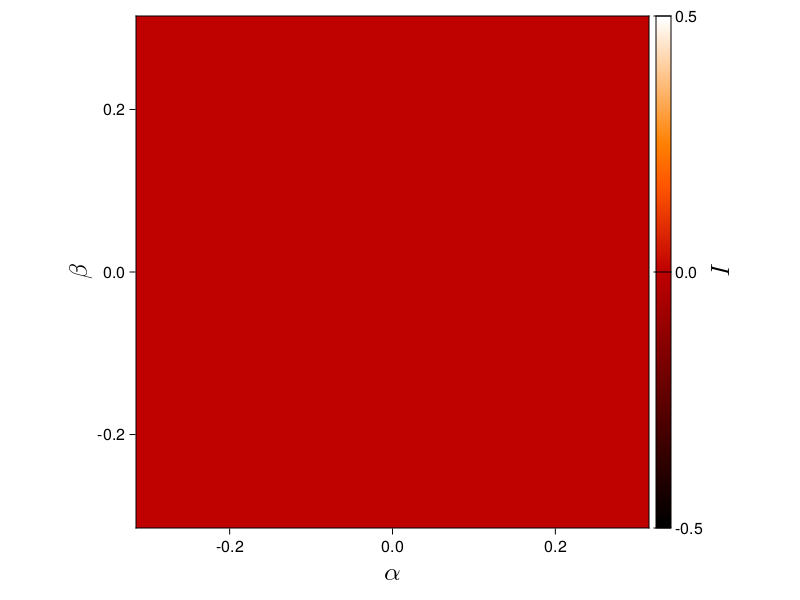

CairoMakie.Screen{IMAGE}


In [13]:
xs, ys = axes_ranges(camera) 
zs = grid_view(output_data, configurations; energy_index = 1)

fig = Figure(font = "CMU Serif") #resolution=(600,400)
ax = Axis(fig[1,1], xlabel=L"\alpha", ylabel=L"\beta", ylabelsize = 26, xlabelsize = 26) 
hmap = heatmap!(xs, ys, zs; colormap=:gist_heat, interpolate=true)
Colorbar(fig[:, end+1], hmap, label=L"I", labelsize=26, width = 15, ticksize = 18, tickalign = 1)
colsize!(fig.layout, 1, Aspect(1, 1.0))
colgap!(fig.layout, 7)
# CairoMakie.save("plot.png", fig)
display(fig)